<a href="https://colab.research.google.com/github/Harmonai-org/sample-generator/blob/main/Dance_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dance Diffusion v0.12

Welcome to the Dance Diffusion beta!

Dance Diffusion is the first in a suite of generative audio tools for producers and musicians to be released by Harmonai. For more info or to get involved in the development of these tools, please visit https://harmonai.org and fill out the form on the front page.

[Click here to ensure you are using the latest version](https://colab.research.google.com/github/Harmonai-org/sample-generator/blob/main/Dance_Diffusion.ipynb)

**Audio diffusion tools in this notebook**:

- Unconditional random audio sample generation
- Audio sample regeneration/style transfer using a single audio file or recording
- Audio interpolation between two audio files

# Instructions



## Before anything else
- Run the "Setup" section
- Sign in to the Google Drive account you want to save your models in
- Select the model you want to sample from in the "Model settings" section, this determines the length and sound of your samples
- Select the sampler you want to use.
- The `save_to_wandb` option futher down adds the ability to log your audio generations to [Weights & Biases](https://www.wandb.ai/site), an experiment tracking and model and data versioning tool.

## For random sample generation
- Choose the number of random samples you would like Dance Diffusion to generate for you 
- Choose the number of diffusion steps you would like Dance Diffusion to execute
- Make sure the "skip_for_run_all" checkbox is unchecked
- Run the cell under the "Generate new sounds" header

## To regenerate your own sounds
- Record a file, enter the path to an audio file you want to regenerate, or upload a file when prompted
- Make sure the "skip_for_run_all" checkbox is unchecked
- Run the cell under the "Regenerate your own sounds" header

## To interpolate between two different sounds
- Enter the paths to two audio files you want to interpolate between, or upload them when prompted
- Make sure the "skip_for_run_all" checkbox is unchecked
- Run the cell under the "Interpolate between sounds" header

## To regenerate sounds using built-in audio recording widget
- Enter a path to save your audio recordings
- Enter the number of audio recordings you want to combine into one
- Run the cell under the "Regenerate your own sound from the recording" header
- Make sure the "skip_for_run_all" checkbox is unchecked

### Credits & License



Original notebook by Zach Evans (https://github.com/zqevans, https://twitter.com/zqevans). 

Overall structure and setup code taken from Disco Diffusion (https://www.discodiffusion.com)

Interpolation and audio display code from CRASH inference notebook (https://github.com/simonrouard/CRASH)

Spruced up by Chris the Wizard (https://twitter.com/chris_wizard)

Audio recording widget added by Niels Bantilan (https://twitter.com/cosmicBboy)


Licensed under the MIT License

Copyright (c) 2022 Zach Evans

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
THE SOFTWARE.


In [2]:
#@title <- View Changelog
skip_for_run_all = True #@param {type: 'boolean'}

if skip_for_run_all == False:
  print(
      '''

  v0.1 Update: Jul 30, 2022 - zqevans
      
      - Added Dance Diffusion notebook

  v0.2 Update: Aug 8, 2022 - zqevans

      - Moved to models trained on 

  v0.3 Update: Aug 11, 2022 - zqevans

      - Reverted to old model architecture
      - Fixed CRASH sampling code

  v0.4 Update: Aug 16, 2022 - zqevans

      - Added jmann-small-190k model

  v0.5 Update: Aug 17, 2022 - zqevans

      - Added interpolations
    
  v0.6 Update: Aug 18, 2022 - zqevans

      - Fixed bug in interpolations

  v0.7 Update: Aug 20, 2022 - zqevans
      - Added maestro-150k model
      - Added unlocked-250k model
      - Improved documentation

  v0.7.1 Update: Aug 21, 2022 - chris the wizard
      - Added introduction
      - Added instructions
      - Added skips for sections
      - Added upload prompts for audio files
      - Removed stale demos

  v0.8 Update: Aug 24, 2022 - zqevans
      - Added Honk model
      - Removed Rave Archive model
      - Added sample length multipliers and batch sizes to regeneration and interpolation

  v0.9 Update: Aug 24, 2022 - zqevans
      - Added glitch.cool model
      - Added jmann-large model
      - Regenerated sounds are now output individually
      - Added custom model sample_size and sample_rate options

  v0.10 Update: Sep 26, 2022 - morganmcg1
      - Added optional, off by default, Weights & Biases logging of the generated audio samples

  v0.11 Update: Oct 27, 2022 - cosmicBboy
      - Added a gradio audio recording widget in the "Regenerate your own sounds" section
      
  v0.12 Update: Nov 3, 2022 - zqevans
      - Added k-diffusion samplers
      - Added option to increase unconditional generation length
    '''
  )

## Install dependencies and restart notebook

**The session will crash to restart automatically, don't worry about the error. This is to ensure the proper dependencies are installed**

**Once the notebook restarts, continue with the steps below**

In [6]:
from IPython.display import clear_output  
import os, signal

#@title Install and restart

#@markdown 

# !git clone https://github.com/harmonai-org/sample-generator
# !git clone --recursive https://github.com/crowsonkb/v-diffusion-pytorch
# !pip install ./sample-generator
# !pip install ./v-diffusion-pytorch
# !pip install ipywidgets==7.7.1 gradio
# !pip install k-diffusion

# os.kill(os.getpid(), signal.SIGKILL)

fatal: destination path 'sample-generator' already exists and is not an empty directory.
fatal: destination path 'v-diffusion-pytorch' already exists and is not an empty directory.
ERROR: Invalid requirement: '/content/sample-generator'
Hint: It looks like a path. File '/content/sample-generator' does not exist.
ERROR: Invalid requirement: '/content/v-diffusion-pytorch'
Hint: It looks like a path. File '/content/v-diffusion-pytorch' does not exist.


## Setup
Run everything in this section before any generation

In [11]:
#@title Check GPU Status
import subprocess
simple_nvidia_smi_display = True#@param {type:"boolean"}
if simple_nvidia_smi_display:
    #!nvidia-smi
    nvidiasmi_output = subprocess.run(['nvidia-smi', '-L'], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(nvidiasmi_output)
else:
    #!nvidia-smi -i 0 -e 0
    nvidiasmi_output = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(nvidiasmi_output)
    nvidiasmi_ecc_note = subprocess.run(['nvidia-smi', '-i', '0', '-e', '0'], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(nvidiasmi_ecc_note)

GPU 0: NVIDIA A10G (UUID: GPU-f2d655bb-65ac-daf8-ff89-f2ced044816c)



In [12]:
#@title Prepare folders
import subprocess, os, sys, ipykernel

def gitclone(url, targetdir=None):
    if targetdir:
        res = subprocess.run(['git', 'clone', url, targetdir], stdout=subprocess.PIPE).stdout.decode('utf-8')
    else:
        res = subprocess.run(['git', 'clone', url], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(res)

def pipi(modulestr):
    res = subprocess.run(['pip', 'install', modulestr], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(res)

def pipie(modulestr):
    res = subprocess.run(['git', 'install', '-e', modulestr], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(res)

def wget(url, outputdir):
    # Using the !wget command instead of the subprocess to get the loading bar
    !wget $url -O $outputdir
    # res = subprocess.run(['wget', url, '-P', f'{outputdir}'], stdout=subprocess.PIPE).stdout.decode('utf-8')
    # print(res)

try:
    from google.colab import drive
    print("Google Colab detected.")
    is_colab = True
    #@markdown Check to connect your Google Drive
    google_drive = True #@param {type:"boolean"}
    if google_drive:
      print("Using Google Drive.")
    #@markdown Click here if you'd like to save the diffusion model checkpoint file to (and/or load from) your Google Drive:
    save_models_to_google_drive = True #@param {type:"boolean"}
except:
    is_colab = False
    google_drive = False
    save_models_to_google_drive = False
    print("Google Colab not detected.")

if is_colab:
    if google_drive is True:
        drive.mount('/content/drive')
        ai_root = '/content/drive/MyDrive/AI'
        root_path = f'{ai_root}/Dance_Diffusion'
    else:
        root_path = '/content'
else:
    root_path = os.getcwd()

import os
def createPath(filepath):
    os.makedirs(filepath, exist_ok=True)

initDirPath = f'{root_path}/init_audio'
createPath(initDirPath)
outDirPath = f'{root_path}/audio_out'
createPath(outDirPath)

if is_colab:
    if google_drive and not save_models_to_google_drive or not google_drive:
        model_path = '/content/models'
        createPath(model_path)
    if google_drive and save_models_to_google_drive:
        model_path = f'{ai_root}/models'
        createPath(model_path)
else:
    model_path = f'{root_path}/models'
    createPath(model_path)

# libraries = f'{root_path}/libraries'
# createPath(libraries)

#@markdown Check the box below to save your generated audio to [Weights & Biases](https://wandb.ai/site)
save_to_wandb = False #@param {type: "boolean"}

if save_to_wandb:
    print("\nInstalling wandb...")
    os.system("pip install -qqq wandb --upgrade")
    import wandb
    # Check if logged in to wandb
    try:
      import netrc
      netrc.netrc().hosts['api.wandb.ai']
      wandb.login()
    except:
      print("\nPlease log in to Weights & Biases...")
      print("1. Sign up for a free wandb account here: https://www.wandb.ai/site")
      print("2. Enter your wandb API key, from https://wandb.ai/authorize, in the field below to log in: \n")
      wandb.login()

Google Colab not detected.


In [14]:
#@title Imports and definitions
from prefigure.prefigure import get_all_args
from contextlib import contextmanager
from copy import deepcopy
import math
from pathlib import Path
# from google.colab import files

import os, signal, sys
import gc

from diffusion import sampling
import torch
from torch import optim, nn
from torch.nn import functional as F
from torch.utils import data
from tqdm import trange
from einops import rearrange

import torchaudio
from audio_diffusion.models import DiffusionAttnUnet1D
import numpy as np

import random
import matplotlib.pyplot as plt
import IPython.display as ipd
from audio_diffusion.utils import Stereo, PadCrop
from glob import glob

#@title Model code
class DiffusionUncond(nn.Module):
    def __init__(self, global_args):
        super().__init__()

        self.diffusion = DiffusionAttnUnet1D(global_args, n_attn_layers = 4)
        self.diffusion_ema = deepcopy(self.diffusion)
        self.rng = torch.quasirandom.SobolEngine(1, scramble=True)

import matplotlib.pyplot as plt
import IPython.display as ipd

def plot_and_hear(audio, sr):
    display(ipd.Audio(audio.cpu().clamp(-1, 1), rate=sr))
    plt.plot(audio.cpu().t().numpy())
  
def load_to_device(path, sr):
    audio, file_sr = torchaudio.load(path)
    if sr != file_sr:
      audio = torchaudio.transforms.Resample(file_sr, sr)(audio)
    audio = audio.to(device)
    return audio

def get_alphas_sigmas(t):
    """Returns the scaling factors for the clean image (alpha) and for the
    noise (sigma), given a timestep."""
    return torch.cos(t * math.pi / 2), torch.sin(t * math.pi / 2)

def get_crash_schedule(t):
    sigma = torch.sin(t * math.pi / 2) ** 2
    alpha = (1 - sigma ** 2) ** 0.5
    return alpha_sigma_to_t(alpha, sigma)

def t_to_alpha_sigma(t):
    """Returns the scaling factors for the clean image and for the noise, given
    a timestep."""
    return torch.cos(t * math.pi / 2), torch.sin(t * math.pi / 2)

def alpha_sigma_to_t(alpha, sigma):
    """Returns a timestep, given the scaling factors for the clean image and for
    the noise."""
    return torch.atan2(sigma, alpha) / math.pi * 2

#@title Args
sample_size = 65536 
sample_rate = 48000   
latent_dim = 0             

class Object(object):
    pass

args = Object()
args.sample_size = sample_size
args.sample_rate = sample_rate
args.latent_dim = latent_dim

#@title Logging
def get_one_channel(audio_data, channel):
  '''
  Takes a numpy audio array and returns 1 channel
  '''
  # Check if the audio has more than 1 channel 
  if len(audio_data.shape) > 1:
    is_stereo = True      
    if np.argmax(audio_data.shape)==0:
        audio_data = audio_data[:,channel] 
    else:
        audio_data = audio_data[channel,:]
  else:
    is_stereo = False

  return audio_data

def log_audio_to_wandb(
    generated, model_name, custom_ckpt_path, steps, batch_size, sample_rate, sample_size, 
    generated_all=None, channel=0, original_sample=None, gen_type='new_sounds', noise_level=None, sample_length_mult=None, file_path=None
    ):

    print('\nSaving your audio generations to Weights & Biases...')

    # Get model name
    if model_name == "custom":
      wandb_model_name = custom_ckpt_path
    else:
      wandb_model_name = model_name
    
    # Create config to log to wandb
    wandb_config = {
      "model":model_name,
      "steps":steps,
      "batch_size":batch_size,
      "sample_rate":sample_rate,
      "sample_size":sample_size,
      "channel":channel,
      "gen_type":gen_type,
      "noise_level":noise_level,
      "sample_length_mult":sample_length_mult,
      "file_path":file_path
    }

    # Create a new wandb run
    wandb.init(project='harmonai-audio-gen', config=wandb_config)
    wandb_run_url = wandb.run.get_url()

    # Create a Weights & Biases Table
    audio_generations_table = wandb.Table(columns=['audio', 'steps', 'model', 'batch_size', 
      'sample_rate', 'sample_size', 'duration'])

    # Add each individual generated sample to a wandb Table
    for idx, g in enumerate(generated.cpu().numpy()):
    
      # Check if the audio has more than 1 channel 
      if idx==0:  
        if len(g.shape) > 1:
          stereo = True      
        else:
          stereo = False

      if stereo:
        g = g[channel]

      duration = np.max(g.shape) / sample_rate 
      wandb_audio =  wandb.Audio(g, sample_rate=sample_rate, caption=wandb_model_name)
      audio_generations_table.add_data(wandb_audio, steps, wandb_model_name, batch_size, 
        sample_rate, sample_size, duration)

    # Log the samples Tables and finish the wandb run
    wandb.log({f'{gen_type}/harmonai_generations' : audio_generations_table})
    
    # Log the combined samples in another wandb Table
    if generated_all is not None:
      g_all = get_one_channel(generated_all, channel)
      duration_all = np.max(g_all.shape) / sample_rate 
      audio_all_generations_table = wandb.Table(columns=['audio', 'steps', 'model', 'batch_size', 
        'sample_rate', 'sample_size', 'duration'])
      wandb_all_audio = wandb.Audio(g_all.cpu().numpy(), sample_rate=sample_rate, caption=wandb_model_name)
      audio_all_generations_table.add_data(wandb_all_audio, steps, wandb_model_name, batch_size, 
        sample_rate, sample_size, duration_all)
      wandb.log({f'{gen_type}/all_harmonai_generations' : audio_all_generations_table})

    if original_sample is not None:
      original_sample = get_one_channel(original_sample, channel)
      audio_original_sample_table = wandb.Table(columns=['audio', 'file_path'])
      wandb_original_audio = wandb.Audio(original_sample, sample_rate=sample_rate)
      audio_original_sample_table.add_data(wandb_original_audio, file_path)
      wandb.log({f'{gen_type}/original_sample' : audio_original_sample_table})
    
    wandb.finish()

    print(f'Your audio generations are saved in Weights & Biases here: {wandb_run_url}\n')

# Model settings

Select the model you want to sample from
---
Model name | Description | Sample rate | Output samples
--- | --- | --- | ---
glitch-440k |Trained on clips from samples provided by [glitch.cool](https://glitch.cool) | 48000 | 65536
jmann-small-190k |Trained on clips from Jonathan Mann's [Song-A-Day](https://songaday.world/) project | 48000 | 65536
jmann-large-580k |Trained on clips from Jonathan Mann's [Song-A-Day](https://songaday.world/) project | 48000 | 131072
maestro-150k |Trained on piano clips from the [MAESTRO](https://magenta.tensorflow.org/datasets/maestro) dataset | 16000 | 65536
unlocked-250k |Trained on clips from the [Unlocked Recordings](https://archive.org/details/unlockedrecordings) dataset | 16000 | 65536
honk-140k |Trained on recordings of the Canada Goose from [xeno-canto](https://xeno-canto.org/) | 16000 | 65536


In [16]:
from urllib.parse import urlparse
import hashlib
import k_diffusion as K

#@title Create the model
model_name = "maestro-150k" #@param ["glitch-440k", "jmann-small-190k", "jmann-large-580k", "maestro-150k", "unlocked-250k", "honk-140k", "custom"]

#@markdown ###Custom options

#@markdown If you have a custom fine-tuned model, choose "custom" above and enter a path to the model checkpoint here

#@markdown These options will not affect non-custom models
custom_ckpt_path = ''#@param {type: 'string'}

custom_sample_rate = 16000 #@param {type: 'number'}
custom_sample_size = 65536 #@param {type: 'number'}

models_map = {

    "glitch-440k": {'downloaded': False,
                         'sha': "48caefdcbb7b15e1a0b3d08587446936302535de74b0e05e0d61beba865ba00a", 
                         'uri_list': ["https://model-server.zqevans2.workers.dev/gwf-440k.ckpt"],
                         'sample_rate': 48000,
                         'sample_size': 65536
                         },
    "jmann-small-190k": {'downloaded': False,
                         'sha': "1e2a23a54e960b80227303d0495247a744fa1296652148da18a4da17c3784e9b", 
                         'uri_list': ["https://model-server.zqevans2.workers.dev/jmann-small-190k.ckpt"],
                         'sample_rate': 48000,
                         'sample_size': 65536
                         },
    "jmann-large-580k": {'downloaded': False,
                         'sha': "6b32b5ff1c666c4719da96a12fd15188fa875d6f79f8dd8e07b4d54676afa096", 
                         'uri_list': ["https://model-server.zqevans2.workers.dev/jmann-large-580k.ckpt"],
                         'sample_rate': 48000,
                         'sample_size': 131072
                         },
    "maestro-150k": {'downloaded': False,
                         'sha': "49d9abcae642e47c2082cec0b2dce95a45dc6e961805b6500204e27122d09485", 
                         'uri_list': ["https://model-server.zqevans2.workers.dev/maestro-uncond-150k.ckpt"],
                         'sample_rate': 16000,
                         'sample_size': 65536
                         },
    "unlocked-250k": {'downloaded': False,
                         'sha': "af337c8416732216eeb52db31dcc0d49a8d48e2b3ecaa524cb854c36b5a3503a", 
                         'uri_list': ["https://model-server.zqevans2.workers.dev/unlocked-uncond-250k.ckpt"],
                         'sample_rate': 16000,
                         'sample_size': 65536
                         },
    "honk-140k": {'downloaded': False,
                         'sha': "a66847844659d287f55b7adbe090224d55aeafdd4c2b3e1e1c6a02992cb6e792", 
                         'uri_list': ["https://model-server.zqevans2.workers.dev/honk-140k.ckpt"],
                         'sample_rate': 16000,
                         'sample_size': 65536
                         },
}

#@markdown If you're having issues with model downloads, check this to compare the SHA:
check_model_SHA = False #@param{type:"boolean"}

def get_model_filename(diffusion_model_name):
    model_uri = models_map[diffusion_model_name]['uri_list'][0]
    model_filename = os.path.basename(urlparse(model_uri).path)
    return model_filename

def download_model(diffusion_model_name, uri_index=0):
    if diffusion_model_name != 'custom':
        model_filename = get_model_filename(diffusion_model_name)
        model_local_path = os.path.join(model_path, model_filename)
        if os.path.exists(model_local_path) and check_model_SHA:
            print(f'Checking {diffusion_model_name} File')
            with open(model_local_path, "rb") as f:
                bytes = f.read() 
                hash = hashlib.sha256(bytes).hexdigest()
                print(f'SHA: {hash}')
            if hash == models_map[diffusion_model_name]['sha']:
                print(f'{diffusion_model_name} SHA matches')
                models_map[diffusion_model_name]['downloaded'] = True
            else:
                print(f"{diffusion_model_name} SHA doesn't match. Will redownload it.")
        elif os.path.exists(model_local_path) and not check_model_SHA or models_map[diffusion_model_name]['downloaded']:
            print(f'{diffusion_model_name} already downloaded. If the file is corrupt, enable check_model_SHA.')
            models_map[diffusion_model_name]['downloaded'] = True

        if not models_map[diffusion_model_name]['downloaded']:
            for model_uri in models_map[diffusion_model_name]['uri_list']:
                wget(model_uri, model_local_path)
                with open(model_local_path, "rb") as f:
                  bytes = f.read() 
                  hash = hashlib.sha256(bytes).hexdigest()
                  print(f'SHA: {hash}')
                if os.path.exists(model_local_path):
                    models_map[diffusion_model_name]['downloaded'] = True
                    return
                else:
                    print(f'{diffusion_model_name} model download from {model_uri} failed. Will try any fallback uri.')
            print(f'{diffusion_model_name} download failed.')

if model_name == "custom":
  ckpt_path = custom_ckpt_path
  args.sample_size = custom_sample_size
  args.sample_rate = custom_sample_rate
else:
  model_info = models_map[model_name]
  download_model(model_name)
  ckpt_path = f'{model_path}/{get_model_filename(model_name)}'
  args.sample_size = model_info["sample_size"]
  args.sample_rate = model_info["sample_rate"]

print("Creating the model...")
model = DiffusionUncond(args)
model.load_state_dict(torch.load(ckpt_path)["state_dict"])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.requires_grad_(False).to(device)
print("Model created")

# # Remove non-EMA
del model.diffusion

model_fn = model.diffusion_ema

maestro-150k already downloaded. If the file is corrupt, enable check_model_SHA.
Creating the model...
Model created


Select the sampler you want to use
---
Sampler name | Notes
--- | ---
v-iplms | This is what the model expects. Needs more steps, but more reliable.
k-heun | Needs fewer steps, but ideal sigma_min and sigma_max need to be found. Doesn't work with all models.
k-lms | "
k-dpm-2 | "
k-dpm-fast | "
k-dpm-adaptive | Takes in extra parameters for quality, step count is non-deterministic

In [17]:
#@title Sampler options
sampler_type = "v-iplms" #@param ["v-iplms", "k-heun", "k-lms", "k-dpm-2", "k-dpm-fast", "k-dpm-adaptive"]

#@markdown ---
#@markdown **K-diffusion settings (advanced)**
sigma_min = 0.0001 #@param {type: "number"}
sigma_max = 1 #@param {type: "number"}
rho=7. #@param {type: "number"}
#@markdown k-dpm-adaptive settings
rtol = 0.01 #@param {type: "number"}
atol = 0.01 #@param {type: "number"}

def sample(model_fn, noise, steps=100, sampler_type="v-iplms", noise_level = 1.0):
  #Check for k-diffusion
  if sampler_type.startswith('k-'):
    denoiser = K.external.VDenoiser(model_fn)
    sigmas = K.sampling.get_sigmas_karras(steps, sigma_min, sigma_max, rho, device=device)

  if sampler_type == "v-iplms":
    t = torch.linspace(1, 0, steps + 1, device=device)[:-1]
    step_list = get_crash_schedule(t)

    return sampling.iplms_sample(model_fn, noise, step_list, {})

  elif sampler_type == "k-heun":
    return K.sampling.sample_heun(denoiser, noise, sigmas, disable=False)
  elif sampler_type == "k-lms":
    return K.sampling.sample_lms(denoiser, noise, sigmas, disable=False)
  elif sampler_type == "k-dpm-2":
    return K.sampling.sample_dpm_2(denoiser, noise, sigmas, disable=False)
  elif sampler_type == "k-dpm-fast":
    return K.sampling.sample_dpm_fast(denoiser, noise, sigma_min, sigma_max, steps, disable=False)
  elif sampler_type == "k-dpm-adaptive":
    return K.sampling.sample_dpm_adaptive(denoiser, noise, sigma_min, sigma_max, rtol=rtol, atol=atol, disable=False)

def resample(model_fn, audio, steps=100, sampler_type="v-iplms", noise_level = 1.0):
  #Noise the input
  if sampler_type == "v-iplms":
    t = torch.linspace(0, 1, steps + 1, device=device)
    step_list = get_crash_schedule(t)
    step_list = step_list[step_list < noise_level]

    alpha, sigma = t_to_alpha_sigma(step_list[-1])
    noised = torch.randn([batch_size, 2, effective_length], device='cuda')
    noised = audio * alpha + noised * sigma

  elif sampler_type.startswith("k-"):
    denoiser = K.external.VDenoiser(model_fn)
    noised = audio + torch.randn_like(audio) * noise_level
    sigmas = K.sampling.get_sigmas_karras(steps, sigma_min, noise_level, rho, device=device)

  # Denoise
  if sampler_type == "v-iplms":
    return sampling.iplms_sample(model_fn, noised, step_list.flip(0)[:-1], {})

  elif sampler_type == "k-heun":
    return K.sampling.sample_heun(denoiser, noised, sigmas, disable=False)

  elif sampler_type == "k-lms":
    return K.sampling.sample_lms(denoiser, noised, sigmas, disable=False)

  elif sampler_type == "k-dpm-2":
    return K.sampling.sample_dpm_2(denoiser, noised, sigmas, s_noise=0., disable=False)

  elif sampler_type == "k-dpm-fast":
    return K.sampling.sample_dpm_fast(denoiser, noised, sigma_min, noise_level, steps, disable=False)

  elif sampler_type == "k-dpm-adaptive":
    return K.sampling.sample_dpm_adaptive(denoiser, noised, sigma_min, noise_level, rtol=rtol, atol=atol, disable=False)

def reverse_sample(model_fn, audio, steps=100, sampler_type="v-iplms", noise_level = 1.0):
  
  if sampler_type == "v-iplms":
    t = torch.linspace(0, 1, steps + 1, device=device)
    step_list = get_crash_schedule(t)

    return sampling.iplms_sample(model_fn, audio_samples, step_list, {}, is_reverse=True)

  elif sampler_type.startswith("k-"):
    denoiser = K.external.VDenoiser(model_fn)
    sigmas = K.sampling.get_sigmas_karras(steps, sigma_min, noise_level, rho, device=device)

  # Denoise
  if sampler_type == "k-heun":
    return K.sampling.sample_heun(denoiser, audio, sigmas.flip(0)[:-1], disable=False)
  elif sampler_type == "k-lms":
    return K.sampling.sample_lms(denoiser, audio, sigmas.flip(0)[:-1], disable=False)
  elif sampler_type == "k-dpm-2":
    return K.sampling.sample_dpm_2(denoiser, audio, sigmas.flip(0)[:-1], s_noise=0., disable=False)
  elif sampler_type == "k-dpm-fast":
    return K.sampling.sample_dpm_fast(denoiser, audio, noise_level, sigma_min, steps, disable=False)

  elif sampler_type == "k-dpm-adaptive":
    return K.sampling.sample_dpm_adaptive(denoiser, audio, noise_level, sigma_min, rtol=rtol, atol=atol, disable=False)





# Generate new sounds

Feeding white noise into the model to be denoised creates novel sounds in the "space" of the training data.

  0%|          | 0/100 [00:00<?, ?it/s]

All samples


sample #1


sample #2


sample #3


sample #4


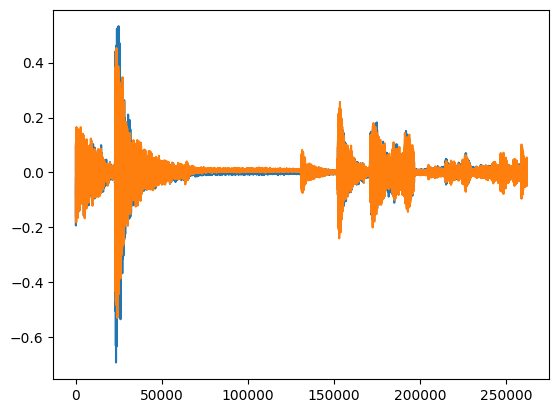

In [18]:
#@markdown How many audio clips to create
batch_size =  4#@param {type:"number"}

#@markdown Number of steps (100 is a good start, more steps trades off speed for quality)
steps = 100 #@param {type:"number"}

#@markdown Multiplier on the default sample length from the model, allows for longer audio clips at the expense of VRAM
sample_length_mult = 1#@param {type:"number"}

#@markdown Check the box below to save your generated audio to [Weights & Biases](https://www.wandb.ai/site)
save_new_generations_to_wandb = False #@param {type: "boolean"}

#@markdown Check the box below to skip this section when running all cells
skip_for_run_all = False #@param {type: "boolean"}

effective_length = sample_length_mult * args.sample_size

if not skip_for_run_all:
  torch.cuda.empty_cache()
  gc.collect()

  # Generate random noise to sample from
  noise = torch.randn([batch_size, 2, effective_length]).to(device)

  generated = sample(model_fn, noise, steps, sampler_type)

  # Hard-clip the generated audio
  generated = generated.clamp(-1, 1)

  # Put the demos together
  generated_all = rearrange(generated, 'b d n -> d (b n)')

  print("All samples")
  plot_and_hear(generated_all, args.sample_rate)
  for ix, gen_sample in enumerate(generated):
    print(f'sample #{ix + 1}')
    display(ipd.Audio(gen_sample.cpu(), rate=args.sample_rate))

  # If Weights & Biases logging enabled, save generations
  if save_new_generations_to_wandb:
    # Check if logged in to wandb
    try:
      import netrc
      netrc.netrc().hosts['api.wandb.ai']

      log_audio_to_wandb(generated, model_name, custom_ckpt_path, steps, batch_size, 
      args.sample_rate, args.sample_size, generated_all=generated_all)
    except:
      print("Not logged in to Weights & Biases, please tick the `save_to_wandb` box at the top of this notebook and run that cell again to log in to Weights & Biases first")

else:
  print("Skipping section, uncheck 'skip_for_run_all' to enable")


# Regenerate your own sounds
By adding noise to an audio file and running it through the model to be denoised, new details will be created, pulling the audio closer to the "sonic space" of the model. The more noise you add, the more the sound will change.

The effect of this is a kind of "style transfer" on the audio. For those familiar with image generation models, this is analogous to an "init image".

In [ ]:
#@title Record audio or enter a filepath to a prerecorded audio file
import torch
import torchaudio
from typing import Iterable, Tuple
import gradio as gr

Audio = Tuple[int, np.ndarray]

#@markdown Check the box below to create an audio recording interface below
record_audio = True #@param {type: "boolean"}

#@markdown If you left "record_audio" blank, enter a path to an audio file you want to alter, or leave blank to upload a file (.wav or .flac).
file_path = "" #@param{type:"string"}

#@markdown Number of audio recordings to combine into one clip. Only applies if the "record_audio" box is checked.
n_audio_recordings = 1 #@param{type:"number"}

# this is a global variable to be filled in by the generate_from_audio callback
recording_file_path = ""


def combine_audio(*audio_iterable: Iterable[Audio]) -> Audio:
    """Combines an iterable of audio signals into one."""
    max_len = max([x.shape for _, x in audio_iterable])
    combined_audio = np.zeros(max_len, dtype=np.int32)
    for _, a in audio_iterable:
        combined_audio[:a.shape[0]] = combined_audio[:a.shape[0]] * .5 + a * .5
    return combined_audio


def generate_from_audio(file_path: str, *audio_iterable: Iterable[Audio]):
    sample_rate = audio_iterable[0][0]
    combined_audio = combine_audio(*audio_iterable)
    tensor = torch.from_numpy(
        np.concatenate(
            [
                combined_audio.reshape(1, -1),
                combined_audio.reshape(1, -1)
            ],
            axis=0,
        )
    )
    global recording_file_path
    recording_file_path = file_path
    torchaudio.save(
        file_path,
        tensor,
        sample_rate=sample_rate,
        format="wav"
    )
    return (sample_rate, combined_audio), file_path

if record_audio:
    recording_interface = gr.Interface(
        fn=generate_from_audio,
        inputs=[
            gr.Textbox(
                "/content/recording.wav",
                label="save recording to filepath",
            ),
            *[
                gr.Audio(source="microphone", label=f"audio clip {i}")
                for i in range(1, n_audio_recordings + 1)
            ]
        ],
        outputs=[
            gr.Audio(label="combined output audio"),
            gr.File(label="output file"),
        ],
        allow_flagging="never",
    )

    recording_interface.launch();
elif file_path == "":
    print("No file path provided, please upload a file")
    # uploaded = files.upload()
    file_path = list(uploaded.keys())[0]

if not record_audio:
    print(f"Using file_path: {file_path} to regenerate new sounds.")

In [ ]:
#@title Generate new sounds from recording

#@markdown Total number of steps (100 is a good start, more steps trades off speed for quality)
steps = 100#@param {type:"number"}

#@markdown How much (0-1) to re-noise the original sample. Adding more noise (a higher number) means a bigger change to the input audio
noise_level = 0.3#@param {type:"number"}

#@markdown Multiplier on the default sample length from the model, allows for longer audio clips at the expense of VRAM
sample_length_mult = 2#@param {type:"number"}

#@markdown How many variations to create
batch_size = 4 #@param {type:"number"}

#@markdown Check the box below to save your generated audio to [Weights & Biases](https://www.wandb.ai/site)
save_own_generations_to_wandb = False #@param {type: "boolean"}

#@markdown Check the box below to skip this section when running all cells
skip_for_run_all = False #@param {type: "boolean"}

effective_length = args.sample_size * sample_length_mult

if not skip_for_run_all:
  torch.cuda.empty_cache()
  gc.collect()

  augs = torch.nn.Sequential(
    PadCrop(effective_length, randomize=True),
    Stereo()
  )

  fp = recording_file_path if record_audio else file_path

  audio_sample = load_to_device(fp, args.sample_rate)

  audio_sample = augs(audio_sample).unsqueeze(0).repeat([batch_size, 1, 1])

  print("Initial audio sample")
  plot_and_hear(audio_sample[0], args.sample_rate)
  
  generated = resample(model_fn, audio_sample, steps, sampler_type, noise_level=noise_level)

  print("Regenerated audio samples")
  plot_and_hear(rearrange(generated, 'b d n -> d (b n)'), args.sample_rate)

  for ix, gen_sample in enumerate(generated):
    print(f'sample #{ix + 1}')
    display(ipd.Audio(gen_sample.cpu(), rate=args.sample_rate))

  # If Weights & Biases logging enabled, save generations
  if save_own_generations_to_wandb:
    # Check if logged in to wandb
    try:
      import netrc
      netrc.netrc().hosts['api.wandb.ai']

      log_audio_to_wandb(generated, model_name, custom_ckpt_path, steps, batch_size, 
        args.sample_rate, args.sample_size, file_path=fp, original_sample=audio_sample[0].cpu().numpy(),
        noise_level=noise_level, gen_type='own_file')
    except:
      print("Not logged in to Weights & Biases, please tick the `save_to_wandb` box at the top of this notebook and run that cell again to log in to Weights & Biases first")

else:
  print("Skipping section, uncheck 'skip_for_run_all' to enable")

# Interpolate between sounds
Diffusion models allow for interpolation between inputs through a process of deterministic noising and denoising. 

By deterministically noising two audio files, interpolating between the results, and deterministically denoising them, we can can create new sounds "between" the audio files provided.

In [ ]:
# Interpolation code taken and modified from CRASH
def compute_interpolation_in_latent(latent1, latent2, lambd):
    '''
    Implementation of Spherical Linear Interpolation: https://en.wikipedia.org/wiki/Slerp
    latent1: tensor of shape (2, n)
    latent2: tensor of shape (2, n)
    lambd: list of floats between 0 and 1 representing the parameter t of the Slerp
    '''
    device = latent1.device
    lambd = torch.tensor(lambd)

    assert(latent1.shape[0] == latent2.shape[0])

    # get the number of channels
    nc = latent1.shape[0]
    interps = []
    for channel in range(nc):
    
      cos_omega = latent1[channel]@latent2[channel] / \
          (torch.linalg.norm(latent1[channel])*torch.linalg.norm(latent2[channel]))
      omega = torch.arccos(cos_omega).item()

      a = torch.sin((1-lambd)*omega) / np.sin(omega)
      b = torch.sin(lambd*omega) / np.sin(omega)
      a = a.unsqueeze(1).to(device)
      b = b.unsqueeze(1).to(device)
      interps.append(a * latent1[channel] + b * latent2[channel])
    return rearrange(torch.cat(interps), "(c b) n -> b c n", c=nc) 

#@markdown Enter the paths to two audio files to interpolate between (.wav or .flac)
source_audio_path = "" #@param{type:"string"}
target_audio_path = "" #@param{type:"string"}

#@markdown Total number of steps (100 is a good start, can go lower for more speed/less quality)
steps = 100#@param {type:"number"}

#@markdown Number of interpolated samples
n_interps = 12 #@param {type:"number"}

#@markdown Multiplier on the default sample length from the model, allows for longer audio clips at the expense of VRAM
sample_length_mult = 1#@param {type:"number"}

#@markdown Check the box below to skip this section when running all cells
skip_for_run_all = False #@param {type: "boolean"}

effective_length = args.sample_size * sample_length_mult

if not skip_for_run_all:

  augs = torch.nn.Sequential(
    PadCrop(effective_length, randomize=True),
    Stereo()
  )

  if source_audio_path == "":
    print("No file path provided for the source audio, please upload a file")
    uploaded = files.upload()
    source_audio_path = list(uploaded.keys())[0]

  audio_sample_1 = load_to_device(source_audio_path, args.sample_rate)

  print("Source audio sample loaded")

  if target_audio_path == "":
    print("No file path provided for the target audio, please upload a file")
    uploaded = files.upload()
    target_audio_path = list(uploaded.keys())[0]

  audio_sample_2 = load_to_device(target_audio_path, args.sample_rate)

  print("Target audio sample loaded")

  audio_samples = augs(audio_sample_1).unsqueeze(0).repeat([2, 1, 1])
  audio_samples[1] = augs(audio_sample_2)

  print("Initial audio samples")
  plot_and_hear(audio_samples[0], args.sample_rate)
  plot_and_hear(audio_samples[1], args.sample_rate)

  reversed = reverse_sample(model_fn, audio_samples, steps)

  latent_series = compute_interpolation_in_latent(reversed[0], reversed[1], [k/n_interps for k in range(n_interps + 2)])

  generated = sample(model_fn, latent_series, steps) 
  
  #sampling.iplms_sample(, latent_series, step_list.flip(0)[:-1], {})

  # Put the demos together
  generated_all = rearrange(generated, 'b d n -> d (b n)')

  print("Full interpolation")
  plot_and_hear(generated_all, args.sample_rate)
  for ix, gen_sample in enumerate(generated):
    print(f'sample #{ix + 1}')
    display(ipd.Audio(gen_sample.cpu(), rate=args.sample_rate))
else:
  print("Skipping section, uncheck 'skip_for_run_all' to enable") 